## Import Basic Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# Import essential models and functions from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

# Import the metrics from sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

CONSTANT_SEED = 100

## Set up Imported Data Set

In [2]:
main_heart_df = pd.read_csv('heart.csv')
main_heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [3]:
# delete a single row by index value 449 - As shown in EDA
main_heart_df = main_heart_df.drop(labels=449, axis=0).reset_index(drop=True)

### Data preperation / One-Hot Encoding

In [4]:
IPzero_heart_df = main_heart_df.copy()

# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
IPzero_heart_df_cat = IPzero_heart_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
ohe.fit(IPzero_heart_df_cat)
IPzero_heart_df_cat_ohe = pd.DataFrame(ohe.transform(IPzero_heart_df_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(IPzero_heart_df_cat.columns))

# Check the encoded variables
IPzero_heart_df_cat_ohe.info()
print('')

# Combining Numeric features with the OHE Categorical features
IPzero_heart_df_num = IPzero_heart_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']]
IPzero_heart_df_res = IPzero_heart_df['HeartDisease']
IPzero_heart_df_ohe = pd.concat([IPzero_heart_df_num, IPzero_heart_df_cat_ohe, IPzero_heart_df_res], 
                           sort = False, axis = 1).reindex(index=IPzero_heart_df_num.index)

# Check the final dataframe
IPzero_heart_df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex_F              917 non-null    float64
 1   Sex_M              917 non-null    float64
 2   ChestPainType_ASY  917 non-null    float64
 3   ChestPainType_ATA  917 non-null    float64
 4   ChestPainType_NAP  917 non-null    float64
 5   ChestPainType_TA   917 non-null    float64
 6   FastingBS_0        917 non-null    float64
 7   FastingBS_1        917 non-null    float64
 8   RestingECG_LVH     917 non-null    float64
 9   RestingECG_Normal  917 non-null    float64
 10  RestingECG_ST      917 non-null    float64
 11  ExerciseAngina_N   917 non-null    float64
 12  ExerciseAngina_Y   917 non-null    float64
 13  ST_Slope_Down      917 non-null    float64
 14  ST_Slope_Flat      917 non-null    float64
 15  ST_Slope_Up        917 non-null    float64
dtypes: float64(16)
memory usag

### Model 1: IPzero_heart_df (Zero imputation / With outliers)

In [5]:
# Extract Response and Predictors
y = pd.DataFrame(IPzero_heart_df_ohe['HeartDisease'])
X = pd.DataFrame(IPzero_heart_df_ohe.drop('HeartDisease', axis = 1))

# Reshape the target variable y to a 1D array
y = y.values.ravel()

### Split data set 

In [6]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = CONSTANT_SEED)

### Finding the Best Parameter found through GridSearchCV

In [7]:
# Define the logistic regression model and hyperparameters for grid search
model = LogisticRegression(max_iter=10000, solver='saga')
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform grid search CV to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score on the training set
print('Best hyperparameters:', grid_search.best_params_)
print('Training set accuracy:', grid_search.best_score_)

C=grid_search.best_params_['C']

Best hyperparameters: {'C': 1}
Training set accuracy: 0.8661429035253165


### Defining Function To Run Logistic Regression Model

In [8]:
def logRModel(C, X_train, X_test, y_train, y_test, grid_search):
    
    # Fit logistic regression model with best hyperparameters on the training data
    best_model = LogisticRegression(max_iter=10000, solver='saga', C=grid_search.best_params_['C'])
    best_model.fit(X_train, y_train)

    # Get the names of the features in X
    feature_names = list(X.columns)

    # Get the coefficients of the logistic regression model
    coefficients = best_model.coef_[0]

    # Create a list of tuples with feature name and absolute coefficient
    coefficients_abs = [(feature_names[i], abs(coefficients[i])) for i in range(len(feature_names))]

    # Sort the list by absolute coefficient in descending order
    coefficients_abs_sorted = sorted(coefficients_abs, key=lambda x: x[1], reverse=True)

    # Create a bar plot of the coefficients
    plt.bar([x[0] for x in coefficients_abs_sorted], [x[1] for x in coefficients_abs_sorted])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient (absolute value)')
    plt.show()
    
    # Evaluate the performance of the model on the train data
    y_pred = best_model.predict(X_train)

    # Evaluate the train model
    accuracy = best_model.score(X_train, y_train)
    report = classification_report(y_train, y_pred)
    print('Accuracy:', accuracy)
    print('')
    print('Classification report:')
    print(report)

    # Evaluate the performance of the model on the train data
    y_pred = best_model.predict(X_test)

    # Evaluate the test model
    accuracy = best_model.score(X_test, y_test)
    report = classification_report(y_test, y_pred)
    print('Accuracy:', accuracy)
    print('')
    print('Classification report:')
    print(report)

    # Predict the Response corresponding to Predictors
    y_train_pred = best_model.predict(X_train)

    # Predict the Response corresponding to Predictors
    y_test_pred = best_model.predict(X_test)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
    plt.show()

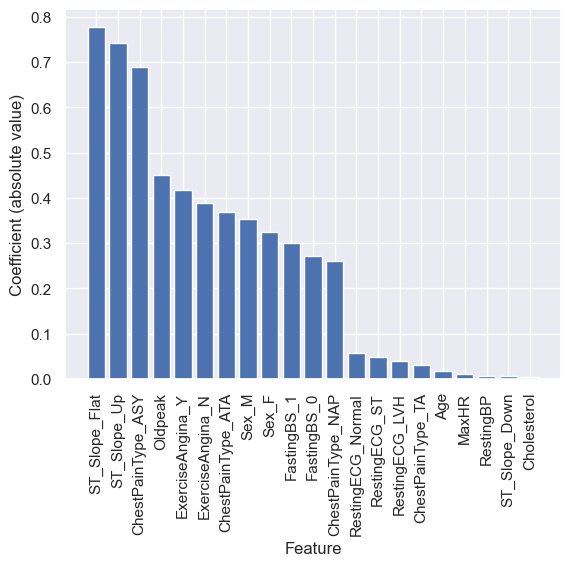

Accuracy: 0.8622100954979536

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       333
           1       0.86      0.89      0.88       400

    accuracy                           0.86       733
   macro avg       0.86      0.86      0.86       733
weighted avg       0.86      0.86      0.86       733

Accuracy: 0.8695652173913043

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        77
           1       0.91      0.86      0.88       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



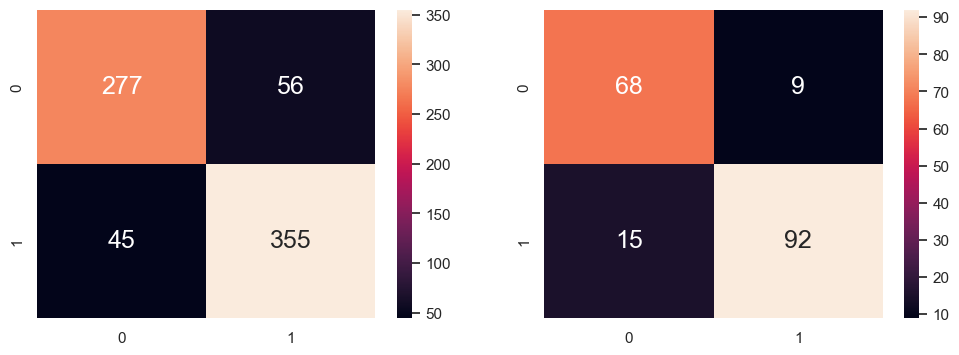

In [9]:
logRModel(C,X_train, X_test, y_train, y_test, grid_search)

### Create a function to repeat the steps above for every model

We would have to implement One Hot Encoding for all of our models. Hence it would be a good idea to create a function to do this for us.

In [10]:
def process(name_df):
    #One hot implementation
    ohe = OneHotEncoder()

    # OneHotEncoding of categorical predictors (not the response)
    name_df_cat = name_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
    ohe.fit(name_df_cat)
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df_cat).toarray(), 
                                      columns=ohe.get_feature_names_out(name_df_cat.columns))

    # Check the encoded variables
    #name_df_cat_ohe.info()

    print('')

    # Combining Numeric features with the OHE Categorical features
    name_df_num = name_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']]
    name_df_res = name_df['HeartDisease']
    name_df_ohe = pd.concat([name_df_num, name_df_cat_ohe , name_df_res], 
                               sort = False, axis = 1).reindex(index=name_df_num.index)
    
    # Check the final dataframe
    name_df_ohe.info()
    
    print('')

    # Extract Response and Predictors
    y = pd.DataFrame(name_df_ohe['HeartDisease'])
    X = pd.DataFrame(name_df_ohe.drop('HeartDisease', axis = 1))

    # Reshape the target variable y to a 1D array
    y = y.values.ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)
    
    # Define the logistic regression model and hyperparameters for grid search
    model = LogisticRegression(max_iter=10000, solver='saga')
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Perform grid search CV to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and the corresponding accuracy score on the training set
    print('Best hyperparameters:', grid_search.best_params_)
    print('Training set accuracy:', grid_search.best_score_)
    
    print('')
    
    # Fit logistic regression model with best hyperparameters on the training data
    best_model = LogisticRegression(max_iter=10000, solver='saga', C=grid_search.best_params_['C'])
    best_model.fit(X_train, y_train)

    # Get the names of the features in X
    feature_names = list(X.columns)

    # Get the coefficients of the logistic regression model
    coefficients = best_model.coef_[0]

    # Create a list of tuples with feature name and absolute coefficient
    coefficients_abs = [(feature_names[i], abs(coefficients[i])) for i in range(len(feature_names))]

    # Sort the list by absolute coefficient in descending order
    coefficients_abs_sorted = sorted(coefficients_abs, key=lambda x: x[1], reverse=True)

    # Create a bar plot of the coefficients
    plt.bar([x[0] for x in coefficients_abs_sorted], [x[1] for x in coefficients_abs_sorted])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient (absolute value)')
    plt.show()
    
    # Evaluate the performance of the model on the train data
    y_pred = best_model.predict(X_train)

    # Evaluate the train model
    accuracy = best_model.score(X_train, y_train)
    report = classification_report(y_train, y_pred)
    print("Goodness of Fit of Model (Train Dataset)")
    print()
    print('Accuracy:', accuracy)
    print('')
    print('Classification report:')
    print(report)

    # Evaluate the performance of the model on the train data
    y_pred = best_model.predict(X_test)

    # Evaluate the test model
    accuracy = best_model.score(X_test, y_test)
    report = classification_report(y_test, y_pred)
    print("Goodness of Fit of Model (Test Dataset)")
    print()
    print('Accuracy:', accuracy)
    print('')
    print('Classification report:')
    print(report)

    # Predict the Response corresponding to Predictors
    y_train_pred = best_model.predict(X_train)

    # Predict the Response corresponding to Predictors
    y_test_pred = best_model.predict(X_test)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
    plt.show()
    
    return 

## Imputation

Imputation is a technique used to fill in missing values in a dataset. The purpose of imputation is to make use of as much of the available data as possible, which can improve the accuracy and reliability of machine learning models. <br><br>

Imputation helps to fill in the missing values with estimates based on the available data. The choice of imputation method depends on the nature of the missing data and the statistical properties of the dataset.  <br><br>

There are various methods of imputation, ranging from simple methods such as mean imputation, to more complex methods such as regression imputation or K-nearest neighbors imputation. For this exploration we will focus on mean and median imputation.  <br><br>

By filling in missing values with imputed values, we can reduce the bias and variability of our estimates, and improve the performance of machine learning models. However, it is important to note that imputation introduces some uncertainty into the dataset, and the choice of imputation method can affect the accuracy and reliability of the results  <br><br>

### Create a function to impute values

In [11]:
def imputer(name_df, method):

    # create SimpleImputer object
    imputer = SimpleImputer(missing_values=0, strategy=method)

    # fit imputer to 'cholesterol' column
    imputer.fit(name_df[['Cholesterol']])

    # transform 'cholesterol' column by replacing 0 with mean value
    name_df['Cholesterol'] = imputer.transform(name_df[['Cholesterol']])
    
    return name_df

### Model 2: IPmean_heart_df (Mean imputation / With outliers)

In [12]:
#Impute mean for every '0' value in Choelestrol
IPmean_heart_df = main_heart_df.copy()
IPmean_heart_df = imputer(IPmean_heart_df, 'mean')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                917 non-null    int64  
 1   RestingBP          917 non-null    int64  
 2   Cholesterol        917 non-null    float64
 3   MaxHR              917 non-null    int64  
 4   Oldpeak            917 non-null    float64
 5   Sex_F              917 non-null    float64
 6   Sex_M              917 non-null    float64
 7   ChestPainType_ASY  917 non-null    float64
 8   ChestPainType_ATA  917 non-null    float64
 9   ChestPainType_NAP  917 non-null    float64
 10  ChestPainType_TA   917 non-null    float64
 11  FastingBS_0        917 non-null    float64
 12  FastingBS_1        917 non-null    float64
 13  RestingECG_LVH     917 non-null    float64
 14  RestingECG_Normal  917 non-null    float64
 15  RestingECG_ST      917 non-null    float64
 16  ExerciseAngina_N   917 no

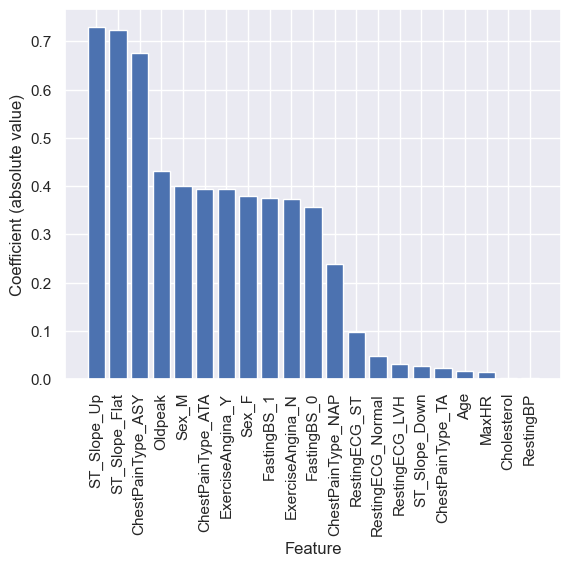

Goodness of Fit of Model (Train Dataset)

Accuracy: 0.8512960436562074

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       333
           1       0.85      0.89      0.87       400

    accuracy                           0.85       733
   macro avg       0.85      0.85      0.85       733
weighted avg       0.85      0.85      0.85       733

Goodness of Fit of Model (Test Dataset)

Accuracy: 0.8858695652173914

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        77
           1       0.93      0.87      0.90       107

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184



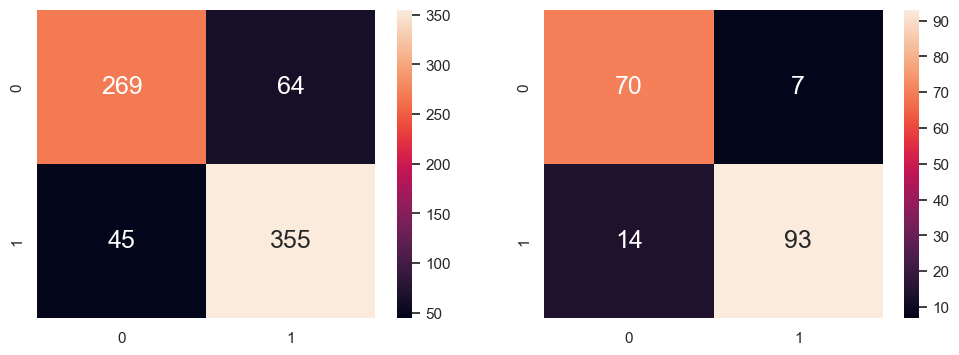

In [13]:
process(IPmean_heart_df)

### Model 3: IPmedian_heart_df (Median imputation / With outliers)¶

In [14]:
#Impute median for every '0' value in Choelestrol
IPmedian_heart_df = main_heart_df.copy()
IPmedian_heart_df = imputer(IPmedian_heart_df, 'median')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                917 non-null    int64  
 1   RestingBP          917 non-null    int64  
 2   Cholesterol        917 non-null    float64
 3   MaxHR              917 non-null    int64  
 4   Oldpeak            917 non-null    float64
 5   Sex_F              917 non-null    float64
 6   Sex_M              917 non-null    float64
 7   ChestPainType_ASY  917 non-null    float64
 8   ChestPainType_ATA  917 non-null    float64
 9   ChestPainType_NAP  917 non-null    float64
 10  ChestPainType_TA   917 non-null    float64
 11  FastingBS_0        917 non-null    float64
 12  FastingBS_1        917 non-null    float64
 13  RestingECG_LVH     917 non-null    float64
 14  RestingECG_Normal  917 non-null    float64
 15  RestingECG_ST      917 non-null    float64
 16  ExerciseAngina_N   917 no

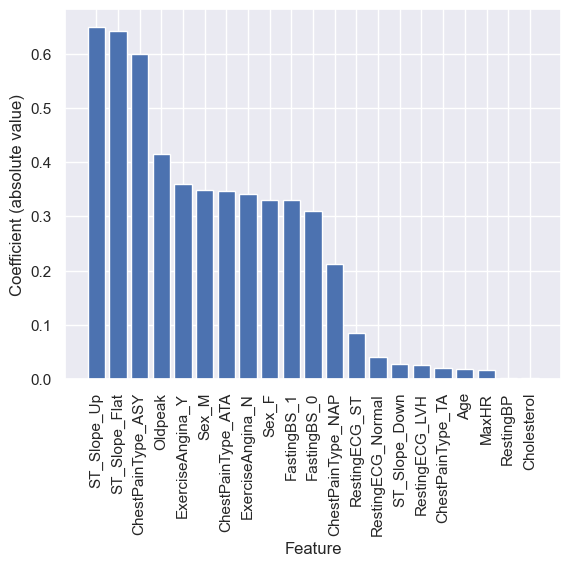

Goodness of Fit of Model (Train Dataset)

Accuracy: 0.849931787175989

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       333
           1       0.85      0.89      0.87       400

    accuracy                           0.85       733
   macro avg       0.85      0.85      0.85       733
weighted avg       0.85      0.85      0.85       733

Goodness of Fit of Model (Test Dataset)

Accuracy: 0.8913043478260869

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        77
           1       0.93      0.88      0.90       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



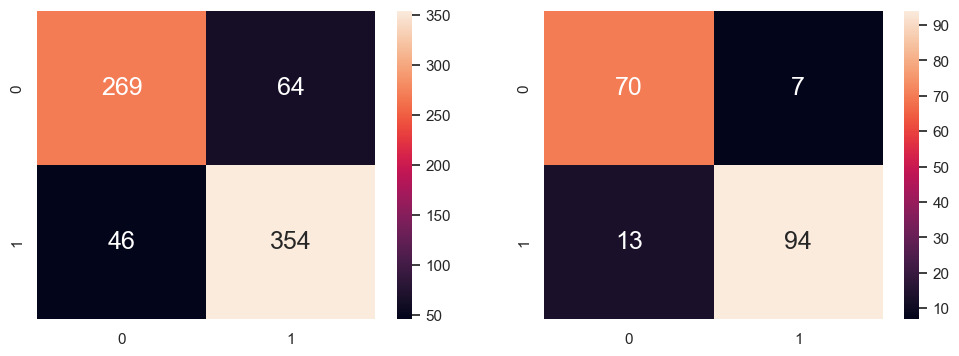

In [15]:
process(IPmedian_heart_df)

## Handle Outliers

### Create a function to remove outliers

In [16]:
# define a function called "Outliers" which returns a list of outliers 
# IQR = Q3-Q1
# +/- 1.5* IQR

def remove_outliers(name_df):
    num_cols = name_df.select_dtypes(include=[np.number]).columns
    cat_cols = name_df.select_dtypes(exclude=[np.number]).columns
    
    Q1 = name_df[num_cols].quantile(0.25)
    Q3 = name_df[num_cols].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = ((name_df[num_cols] < lower_bound) | (name_df[num_cols] > upper_bound)).any(axis=1)
    
    return name_df.loc[~outlier_mask, :]

Let's see if removing outliers would result in a better Model

### Model 4: IPzero_N0_outliers_heart_df (No imputation / Without outliers)¶

In [17]:
# Deleting Outliers and creating new Dataframe IPzero_N0_outliers_heart_df
IPzero_N0_outliers_heart_df = main_heart_df.copy()
IPzero_N0_outliers_heart_df = remove_outliers(IPzero_N0_outliers_heart_df).reset_index(drop=True)



In [18]:
IPzero_N0_outliers_heart_df


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
583,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
584,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
585,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
586,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                588 non-null    int64  
 1   RestingBP          588 non-null    int64  
 2   Cholesterol        588 non-null    int64  
 3   MaxHR              588 non-null    int64  
 4   Oldpeak            588 non-null    float64
 5   Sex_F              588 non-null    float64
 6   Sex_M              588 non-null    float64
 7   ChestPainType_ASY  588 non-null    float64
 8   ChestPainType_ATA  588 non-null    float64
 9   ChestPainType_NAP  588 non-null    float64
 10  ChestPainType_TA   588 non-null    float64
 11  FastingBS_0        588 non-null    float64
 12  RestingECG_LVH     588 non-null    float64
 13  RestingECG_Normal  588 non-null    float64
 14  RestingECG_ST      588 non-null    float64
 15  ExerciseAngina_N   588 non-null    float64
 16  ExerciseAngina_Y   588 no

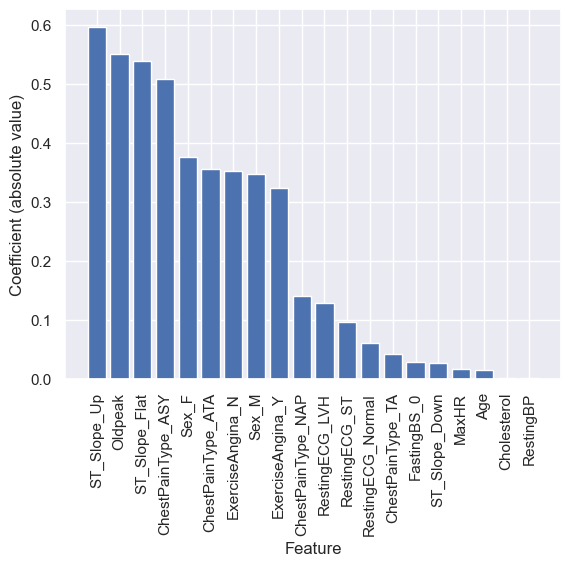

Goodness of Fit of Model (Train Dataset)

Accuracy: 0.8468085106382979

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       270
           1       0.82      0.81      0.82       200

    accuracy                           0.85       470
   macro avg       0.84      0.84      0.84       470
weighted avg       0.85      0.85      0.85       470

Goodness of Fit of Model (Test Dataset)

Accuracy: 0.8728813559322034

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        67
           1       0.91      0.78      0.84        51

    accuracy                           0.87       118
   macro avg       0.88      0.86      0.87       118
weighted avg       0.88      0.87      0.87       118



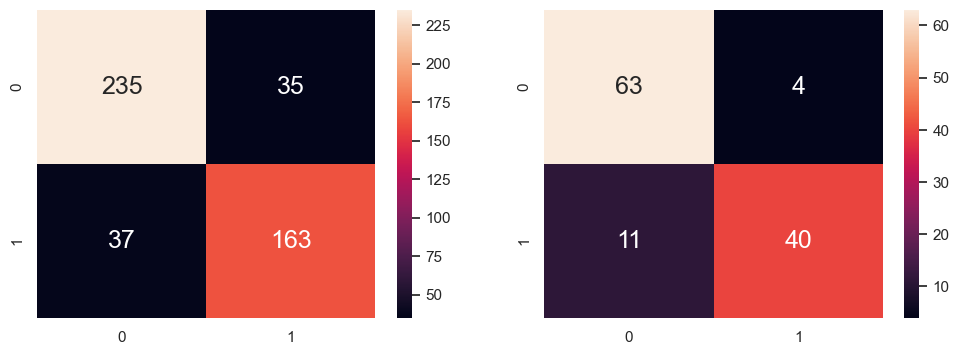

In [19]:
process(IPzero_N0_outliers_heart_df)

### Model 5: IPmean_N0_outliers_heart_df (Mean imputation / Without outliers)

In [20]:
# Deleting Outliers and creating new Dataframe IPmean_N0_outliers_heart_df
IPmean_N0_outliers_heart_df = main_heart_df.copy()

#Impute mean for every '0' value in Choelestrol
IPmean_N0_outliers_heart_df = imputer(IPmean_N0_outliers_heart_df, 'mean')

#Remove outliers 
IPmean_N0_outliers_heart_df = remove_outliers(IPmean_N0_outliers_heart_df).reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                642 non-null    int64  
 1   RestingBP          642 non-null    int64  
 2   Cholesterol        642 non-null    float64
 3   MaxHR              642 non-null    int64  
 4   Oldpeak            642 non-null    float64
 5   Sex_F              642 non-null    float64
 6   Sex_M              642 non-null    float64
 7   ChestPainType_ASY  642 non-null    float64
 8   ChestPainType_ATA  642 non-null    float64
 9   ChestPainType_NAP  642 non-null    float64
 10  ChestPainType_TA   642 non-null    float64
 11  FastingBS_0        642 non-null    float64
 12  RestingECG_LVH     642 non-null    float64
 13  RestingECG_Normal  642 non-null    float64
 14  RestingECG_ST      642 non-null    float64
 15  ExerciseAngina_N   642 non-null    float64
 16  ExerciseAngina_Y   642 no

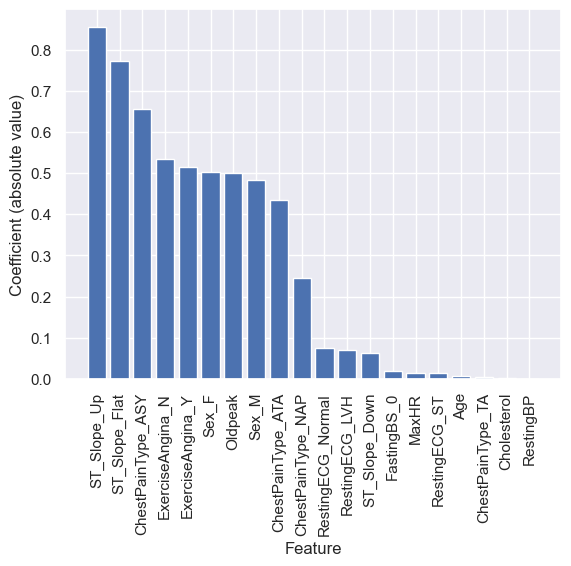

Goodness of Fit of Model (Train Dataset)

Accuracy: 0.8615984405458089

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       277
           1       0.85      0.85      0.85       236

    accuracy                           0.86       513
   macro avg       0.86      0.86      0.86       513
weighted avg       0.86      0.86      0.86       513

Goodness of Fit of Model (Test Dataset)

Accuracy: 0.8294573643410853

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        67
           1       0.82      0.82      0.82        62

    accuracy                           0.83       129
   macro avg       0.83      0.83      0.83       129
weighted avg       0.83      0.83      0.83       129



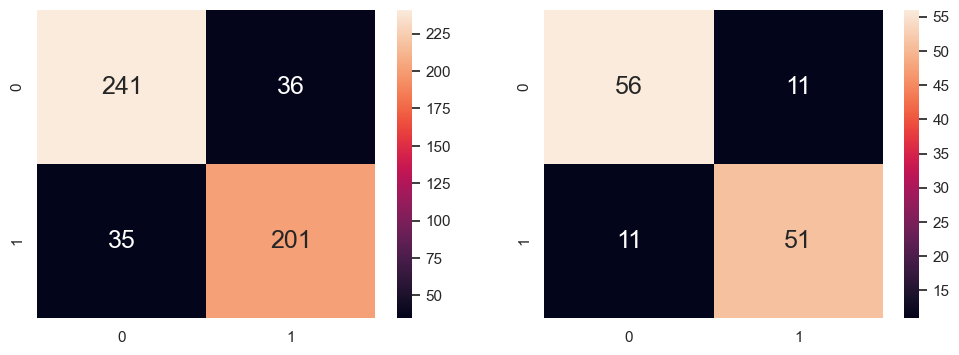

In [21]:
process(IPmean_N0_outliers_heart_df)

### Model 6: IPmedian_N0_outliers_heart_df (Median imputation / Without outliers)

In [22]:
# Deleting Outliers and creating new Dataframe IPmedian_N0_outliers_heart_df
IPmedian_N0_outliers_heart_df = main_heart_df.copy()

#Impute median for every '0' value in Choelestrol
IPmedian_N0_outliers_heart_df = imputer(IPmedian_N0_outliers_heart_df, 'median')

#Remove outliers 
IPmedian_N0_outliers_heart_df = remove_outliers(IPmedian_N0_outliers_heart_df).reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                642 non-null    int64  
 1   RestingBP          642 non-null    int64  
 2   Cholesterol        642 non-null    float64
 3   MaxHR              642 non-null    int64  
 4   Oldpeak            642 non-null    float64
 5   Sex_F              642 non-null    float64
 6   Sex_M              642 non-null    float64
 7   ChestPainType_ASY  642 non-null    float64
 8   ChestPainType_ATA  642 non-null    float64
 9   ChestPainType_NAP  642 non-null    float64
 10  ChestPainType_TA   642 non-null    float64
 11  FastingBS_0        642 non-null    float64
 12  RestingECG_LVH     642 non-null    float64
 13  RestingECG_Normal  642 non-null    float64
 14  RestingECG_ST      642 non-null    float64
 15  ExerciseAngina_N   642 non-null    float64
 16  ExerciseAngina_Y   642 no

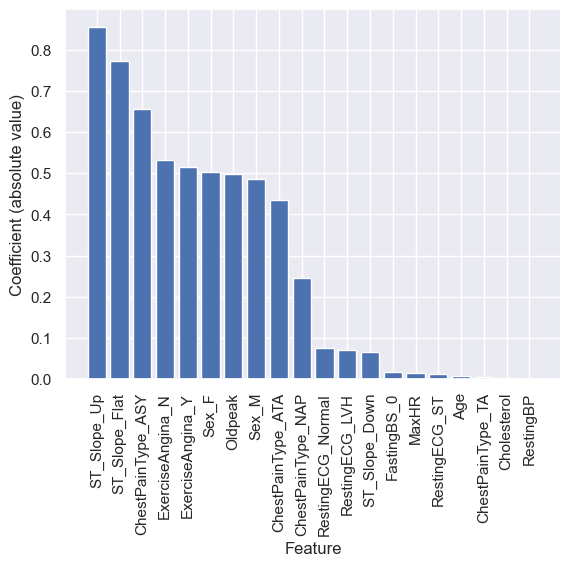

Goodness of Fit of Model (Train Dataset)

Accuracy: 0.8596491228070176

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       277
           1       0.85      0.85      0.85       236

    accuracy                           0.86       513
   macro avg       0.86      0.86      0.86       513
weighted avg       0.86      0.86      0.86       513

Goodness of Fit of Model (Test Dataset)

Accuracy: 0.8294573643410853

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        67
           1       0.82      0.82      0.82        62

    accuracy                           0.83       129
   macro avg       0.83      0.83      0.83       129
weighted avg       0.83      0.83      0.83       129



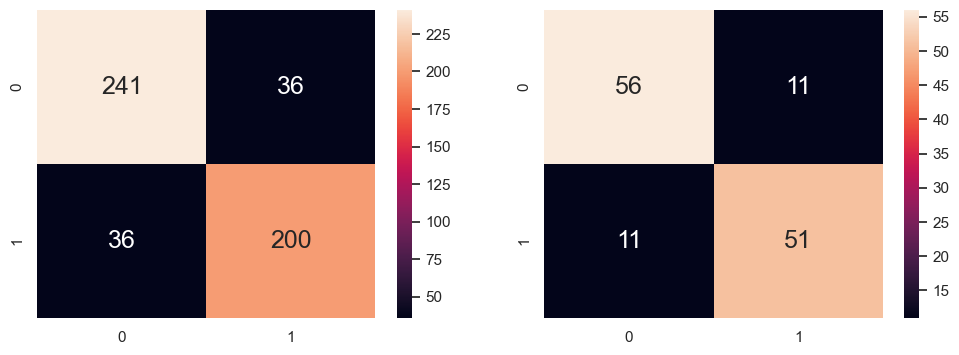

In [23]:
process(IPmedian_N0_outliers_heart_df)

## Classification Report Across All Models

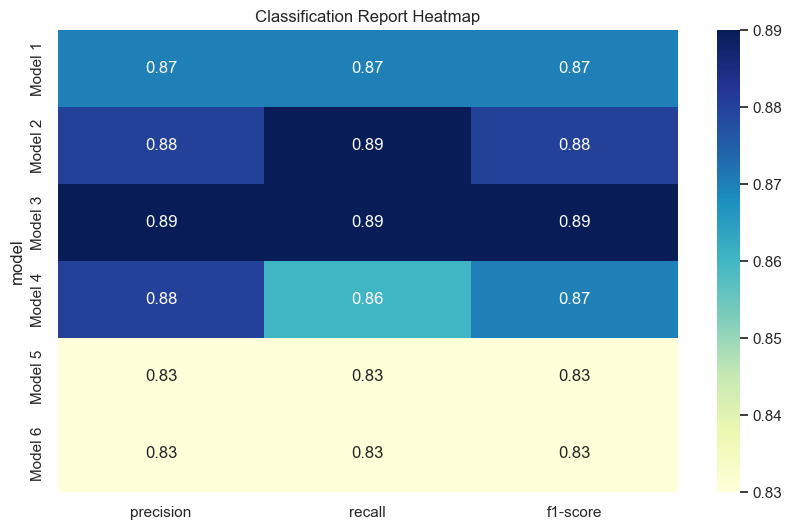

In [24]:
# create a list of all the classification reports using the macro avg
reports = [
    {'model': 'Model 1', 'precision': 0.87, 'recall': 0.87, 'f1-score': 0.87},
    {'model': 'Model 2', 'precision': 0.88, 'recall': 0.89, 'f1-score': 0.88},
    {'model': 'Model 3', 'precision': 0.89, 'recall': 0.89, 'f1-score': 0.89},
    {'model': 'Model 4', 'precision': 0.88, 'recall': 0.86, 'f1-score': 0.87},
    {'model': 'Model 5', 'precision': 0.83, 'recall': 0.83, 'f1-score': 0.83},
    {'model': 'Model 6', 'precision': 0.83, 'recall': 0.83, 'f1-score': 0.83}
]

# create a dataframe from the classification reports
df = pd.DataFrame(reports)

# set the model column as the index
df.set_index('model', inplace=True)

# create a heatmap using seaborn
plt.figure(figsize=(10,6))
sb.heatmap(df, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()


MODEL 1 : Zero Imputation 

MODEL 2 : Mean Imputation 

MODEL 3 : Median Imputation 

MODEL 4 : Zero Imputation without Outliers

MODEL 5 : Mean Imputation without Outliers

MODEL 6 : Median Imputation without Outliers

### Evaluation 

Comparing the performance of the models with zero, mean, and median imputation (models 1, 2, and 3) suggests that median imputation resulted in the best overall performance. Specifically, **model 3 achieved the highest scores for all three metrics**. This is consistent with the idea that median imputation is often preferred over mean imputation in cases where the data has a skewed distribution or contains outliers. Since median is less sensitive to outliers than mean, it is better suited for imputing missing values in such cases.

Comparing the performance of the models with and without outliers removed (models 1-3 vs models 4-6) suggests that removing outliers did not have a significant impact on the performance of the models. In some cases, the models with outliers removed performed slightly worse than the models without outlier removal (models 4 and 6). This suggests that the outliers in the data may not have had a significant impact on the performance of the models, and that removing them did not provide much benefit

This also **might** indicate the Logistic Regression Model Model is more sensitive to outliers, and by removing them , it leads to a lower F1 score (with the exception of the zero imputation where it remained the same). 


Ultimately , **model 3 is the best model across all imputation and within imputation.**

## Feature pruning the best model

### Finding the most important features in the best model (Zero Imputation without outliers)

Best hyperparameters: {'C': 0.1}
Training set accuracy: 0.8590162376385798


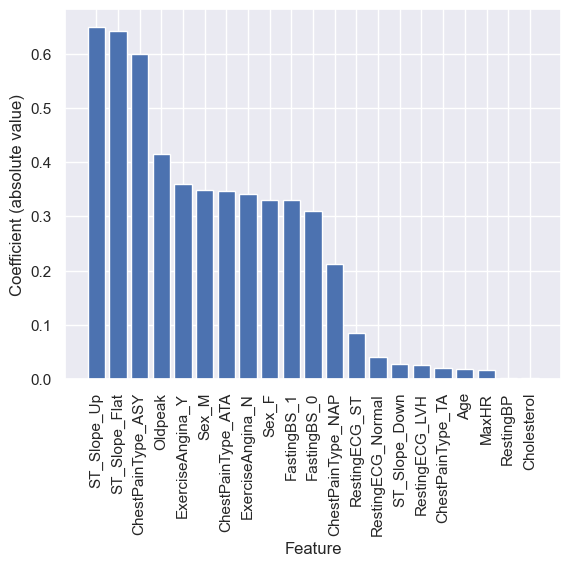

In [25]:
IPmedian_heart_df = main_heart_df.copy()
IPmedian_heart_df = imputer(IPmedian_heart_df, 'median')

ohe = OneHotEncoder()

# OneHotEncoding of categorical predictors (not the response)
IPmedian_heart_df_cat = IPzero_heart_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
ohe.fit(IPmedian_heart_df_cat)
IPmedian_heart_df_cat_ohe = pd.DataFrame(ohe.transform(IPmedian_heart_df_cat).toarray(), 
                                  columns=ohe.get_feature_names_out(IPmedian_heart_df_cat.columns))

# Combining Numeric features with the OHE Categorical features
IPmedian_heart_df_num = IPmedian_heart_df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']]
IPmedian_heart_df_res = IPmedian_heart_df['HeartDisease']
IPmedian_heart_df_ohe = pd.concat([IPmedian_heart_df_num, IPmedian_heart_df_cat_ohe, IPmedian_heart_df_res], 
                           sort = False, axis = 1).reindex(index=IPmedian_heart_df_num.index)

# Extract Response and Predictors
y = pd.DataFrame(IPmedian_heart_df_ohe['HeartDisease'])
X = pd.DataFrame(IPmedian_heart_df_ohe.drop('HeartDisease', axis = 1))

# Reshape the target variable y to a 1D array
y = y.values.ravel()

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = CONSTANT_SEED)

# Define the logistic regression model and hyperparameters for grid search
model = LogisticRegression(max_iter=10000, solver='saga')
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform grid search CV to find the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding accuracy score on the training set
print('Best hyperparameters:', grid_search.best_params_)
print('Training set accuracy:', grid_search.best_score_)

# Fit logistic regression model with best hyperparameters on the training data
best_model = LogisticRegression(max_iter=10000, solver='saga', C=grid_search.best_params_['C'])
best_model.fit(X_train, y_train)

# Get the names of the features in X
feature_names = list(X.columns)

# Get the coefficients of the logistic regression model
coefficients = best_model.coef_[0]

# Create a list of tuples with feature name and absolute coefficient
coefficients_abs = [(feature_names[i], abs(coefficients[i])) for i in range(len(feature_names))]

# Sort the list by absolute coefficient in descending order
coefficients_abs_sorted = sorted(coefficients_abs, key=lambda x: x[1], reverse=True)

# Create a bar plot of the coefficients
plt.bar([x[0] for x in coefficients_abs_sorted], [x[1] for x in coefficients_abs_sorted])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient (absolute value)')
plt.show()

In [26]:
from sklearn import metrics

# Evaluate the model on the test data
y_test_pred = best_model.predict(X_test)
f1_score_before_pruning = metrics.f1_score(y_test, y_test_pred, average='macro')

print("Initial Test Data")
print(classification_report(y_test,y_test_pred))
print(f"F1 score with all features: {f1_score_before_pruning:.4f}")
print()

# Remove all features with coefficient 0
X_train_pruned = X_train.loc[:, (best_model.coef_ != 0).any(axis=0)]
X_test_pruned = X_test.loc[:, (best_model.coef_ != 0).any(axis=0)]
best_model.fit(X_train_pruned, y_train)
y_test_pred = best_model.predict(X_test_pruned)
f1_score_after_stage_1 = metrics.f1_score(y_test, y_test_pred, average='macro')

print("After removing all features with coefficient importance of 0")
print(metrics.classification_report(y_test, y_test_pred))
print(f"F1 score after removing all 0 coefficient importance features: {f1_score_after_stage_1:.4f}")
print()

# Create a list of feature names
feature_names = list(X_train_pruned.columns)

# Remove one feature at a time until only 3 features are left
f1_scores_stage_2 = [f1_score_after_stage_1]
num_features = [len(feature_names)]


for i in range(len(coefficients_abs_sorted)-4):
    # Remove the feature with the lowest absolute coefficient
    feature_to_drop = coefficients_abs_sorted[-1][0]
    feature_names.remove(feature_to_drop)
    coefficients_abs_sorted.pop(-1)
    
    # Print the removed feature
    print(f"Removed feature: {feature_to_drop}")
    
    # Update the training and test dataframes to remove the feature
    X_train_pruned = X_train_pruned[feature_names]
    X_test_pruned = X_test_pruned[feature_names]
    
    # Fit the model and evaluate its performance
    best_model.fit(X_train_pruned, y_train)
    y_test_pred = best_model.predict(X_test_pruned)
    f1_score = metrics.f1_score(y_test, y_test_pred ,average='macro')
    f1_scores_stage_2.append(f1_score)
    num_features.append(len(feature_names))
    
    # Print the classification report
    print(f"Classification report after removing feature {feature_to_drop}:")
    print(metrics.classification_report(y_test, y_test_pred))
    print()

# Remove pruned features from X_test
X_test_pruned = X_test_pruned[feature_names]

# Evaluate the final model on the pruned test data

print("Final Test Data")
print(classification_report(y_test,best_model.predict(X_test_pruned)))
print()


Initial Test Data
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        77
           1       0.93      0.88      0.90       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184

F1 score with all features: 0.8894

After removing all features with coefficient importance of 0
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        77
           1       0.93      0.88      0.90       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184

F1 score after removing all 0 coefficient importance features: 0.8894

Removed feature: Cholesterol
Classification report after removing feature Cholesterol:
              precision    recall  f1-score   support

           0      

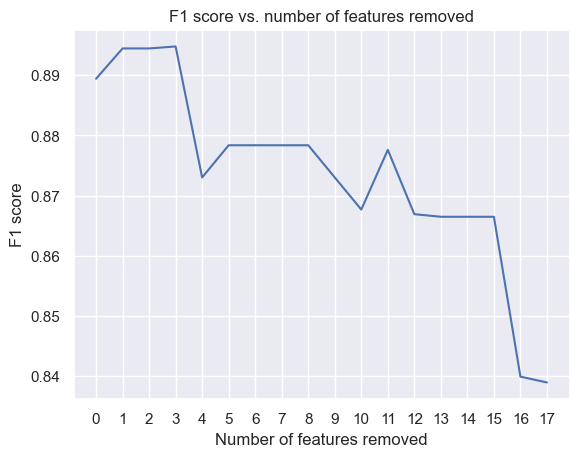

In [27]:
num_features_removed = list(range(0, len(f1_scores_stage_2)))
plt.plot(num_features_removed, f1_scores_stage_2)
plt.xlabel('Number of features removed')
plt.ylabel('F1 score')
plt.title('F1 score vs. number of features removed')
plt.xticks(num_features_removed)
plt.show()


## Evaluation 

There are 2 instances of distinct drops in f1 Score, 

1) When **'Age'** (Feature 4) was removed. It seems that **'Age'** might play a bigger role in determining is a patient would have **'HeartDisease'**. 

2) when **'Sex_M'** (Feature 15) was removed. This might indicate that the following more important features namely : **'ST_Slope_Up'** , **'ST_Slope_Flat'** , **'ChestPainType_ASY'** , **'ExerciseAngina_Y'** and **'Oldpeak'** are important features in determining if a patient has **'HeartDisease'**.
 

## Feature Conclusion 

**'Age'** , **'Sex_M'** , **'ST_Slope_Up'** , **'ST_Slope_Flat'** , **'ChestPainType_ASY'** , **'ExerciseAngina_Y'** and **'Oldpeak'** are the most important variables that might indicate a patient has **'HeartDisease'**

## Best Model with Best feature

In [28]:
IPmedian_heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
912,45,M,TA,110,264.0,0,Normal,132,N,1.2,Flat,1
913,68,M,ASY,144,193.0,1,Normal,141,N,3.4,Flat,1
914,57,M,ASY,130,131.0,0,Normal,115,Y,1.2,Flat,1
915,57,F,ATA,130,236.0,0,LVH,174,N,0.0,Flat,1


In [29]:
def Best_model_process(name_df):
    #One hot implementation
    ohe = OneHotEncoder()

    # OneHotEncoding of categorical predictors (not the response)
    name_df_cat = name_df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']]
    ohe.fit(name_df_cat)
    name_df_cat_ohe = pd.DataFrame(ohe.transform(name_df_cat).toarray(), 
                                      columns=ohe.get_feature_names_out(name_df_cat.columns))

    # Check the encoded variables
    #name_df_cat_ohe.info()
    
    # Select the binary columns to keep
    bin_cols = ['Sex_M', 'ST_Slope_Up', 'ST_Slope_Flat',
                'ChestPainType_ASY', 'ExerciseAngina_Y']
    
    
    print('')

    # Combining Numeric features with the OHE Categorical features
    name_df_num = name_df[['Age','Oldpeak']]
    name_df_res = name_df['HeartDisease']
    # Combine the selected columns into a final DataFrame
    name_df_selected = pd.concat([name_df_num, name_df_cat_ohe[bin_cols], name_df_res],
                                  sort = False, axis = 1).reindex(index=name_df_num.index)
    
    # Check the final dataframe
    name_df_selected.info()
    
    print('')

    # Extract Response and Predictors
    y = pd.DataFrame(name_df_selected['HeartDisease'])
    X = pd.DataFrame(name_df_selected.drop('HeartDisease', axis = 1))

    # Reshape the target variable y to a 1D array
    y = y.values.ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = CONSTANT_SEED)
    
    # Define the logistic regression model and hyperparameters for grid search
    model = LogisticRegression(max_iter=10000, solver='saga')
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Perform grid search CV to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and the corresponding accuracy score on the training set
    print('Best hyperparameters:', grid_search.best_params_)
    print('Training set accuracy:', grid_search.best_score_)
    
    print('')
    
    # Fit logistic regression model with best hyperparameters on the training data
    best_model = LogisticRegression(max_iter=10000, solver='saga', C=grid_search.best_params_['C'])
    best_model.fit(X_train, y_train)

    # Get the names of the features in X
    feature_names = list(X.columns)

    # Get the coefficients of the logistic regression model
    coefficients = best_model.coef_[0]

    # Create a list of tuples with feature name and absolute coefficient
    coefficients_abs = [(feature_names[i], abs(coefficients[i])) for i in range(len(feature_names))]

    # Sort the list by absolute coefficient in descending order
    coefficients_abs_sorted = sorted(coefficients_abs, key=lambda x: x[1], reverse=True)

    # Create a bar plot of the coefficients
    plt.bar([x[0] for x in coefficients_abs_sorted], [x[1] for x in coefficients_abs_sorted])
    plt.xticks(rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient (absolute value)')
    plt.show()
    
    # Evaluate the performance of the model on the train data
    y_pred = best_model.predict(X_train)

    # Evaluate the train model
    accuracy = best_model.score(X_train, y_train)
    report = classification_report(y_train, y_pred)
    print("Goodness of Fit of Model (Train Dataset)")
    print()
    print('Accuracy:', accuracy)
    print('')
    print('Classification report:')
    print(report)

    # Evaluate the performance of the model on the train data
    y_pred = best_model.predict(X_test)

    # Evaluate the test model
    accuracy = best_model.score(X_test, y_test)
    report = classification_report(y_test, y_pred)
    print("Goodness of Fit of Model (Test Dataset)")
    print()
    print('Accuracy:', accuracy)
    print('')
    print('Classification report:')
    print(report)

    # Predict the Response corresponding to Predictors
    y_train_pred = best_model.predict(X_train)

    # Predict the Response corresponding to Predictors
    y_test_pred = best_model.predict(X_test)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
    plt.show()
    
    return 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                917 non-null    int64  
 1   Oldpeak            917 non-null    float64
 2   Sex_M              917 non-null    float64
 3   ST_Slope_Up        917 non-null    float64
 4   ST_Slope_Flat      917 non-null    float64
 5   ChestPainType_ASY  917 non-null    float64
 6   ExerciseAngina_Y   917 non-null    float64
 7   HeartDisease       917 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 57.4 KB

Best hyperparameters: {'C': 100}
Training set accuracy: 0.8678037120910908



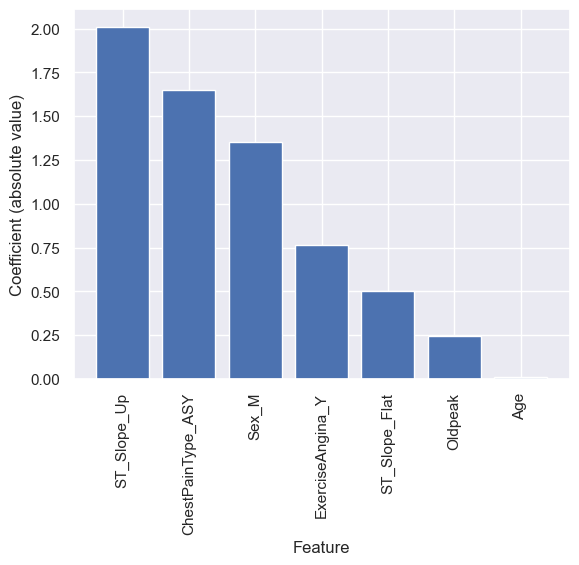

Goodness of Fit of Model (Train Dataset)

Accuracy: 0.8512960436562074

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       333
           1       0.85      0.89      0.87       400

    accuracy                           0.85       733
   macro avg       0.85      0.85      0.85       733
weighted avg       0.85      0.85      0.85       733

Goodness of Fit of Model (Test Dataset)

Accuracy: 0.8641304347826086

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



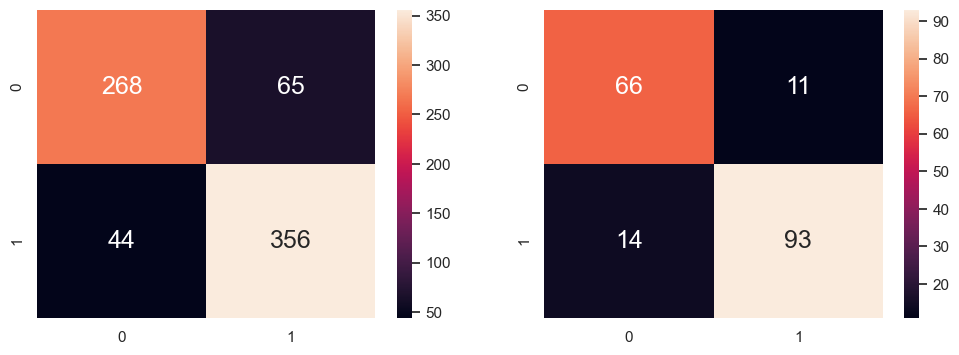

In [30]:
Best_model_process(IPmedian_heart_df)

## Evaluation of model before and after feature pruning 

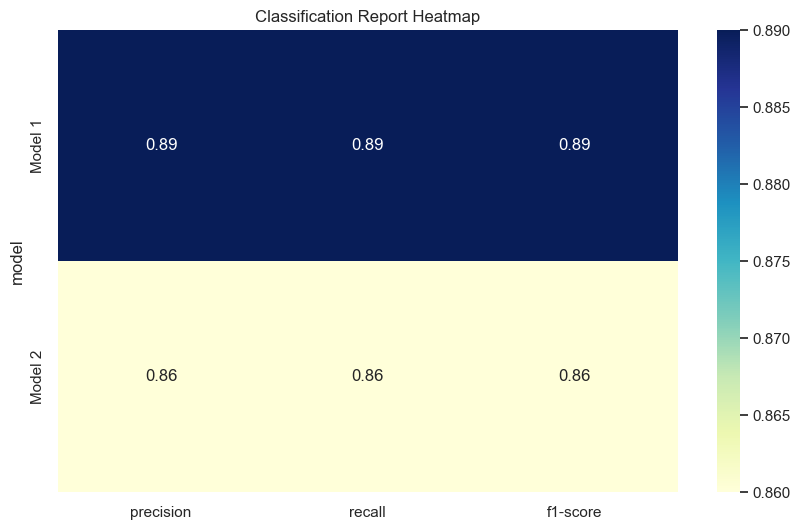

In [31]:
# create a list of all the classification reports

reports = [
    {'model': 'Model 1', 'precision': 0.89, 'recall': 0.89, 'f1-score': 0.89},
    {'model': 'Model 2', 'precision': 0.86, 'recall': 0.86, 'f1-score': 0.86},
    
]

# create a dataframe from the classification reports
df = pd.DataFrame(reports)

# set the model column as the index
df.set_index('model', inplace=True)

# create a heatmap using seaborn
plt.figure(figsize=(10,6))
sb.heatmap(df, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Classification Report Heatmap')
plt.show()

MODEL 1: IPmedian_heart_df Before feature pruning 

MODEL 2: IPmedian_heart_df After feature pruning 

There is a 0.3 decrease in F1 score between the 2 models. This shows that **'Age'** , **'Sex_M'** , **'ST_Slope_Up'** , **'ST_Slope_Flat'** , **'ChestPainType_ASY'** , **'ExerciseAngina_Y'** and **'Oldpeak'** might be important features in indicating a patient has **'HeartDisease'** . 

However, this poor performance also suggest that logistic regression might not be great machine learning model to predict if a patient has **'HeartDisease'** .

Hence, this might require another machine learning model to predict for **'HeartDisease'**. 